In [1]:
import os

from mypy.checkexpr import defaultdict

from src.utils import working_directory_to_src
working_directory_to_src()   # run this only once after starting the kernel.

Path set to : /Users/aakashsingh/Documents/Developer/spring-2026-group4/src


1

In [72]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import read_yaml, read_jsonl, remove_outliers
from tqdm import tqdm
import math
from collections import Counter, defaultdict
from datetime import timedelta

config = read_yaml('config.yaml')
config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'DATA_FOLDER': '../data',
 'NEWS_FOLDER': '../data/multi-modal-dataset/sp500_news',
 'DATA_DICTIONARY': '../data/multi-modal-dataset/sp500stock_data_description.csv',
 'STOCK_SCORE_NEWS': '../data/multi-modal-dataset/stock_scores_news_1.csv'}

In [3]:
list_of_tickers = os.listdir(config["NEWS_FOLDER"])
list_of_tickers.sort()
number_of_tickers = len(list_of_tickers)
print("Number of Tickers:", number_of_tickers)

Number of Tickers: 4694


## Number of articles per Ticker

In [4]:
ticker_n_articles = {}
for ticker in tqdm(list_of_tickers):
    data = read_jsonl(os.path.join(config["NEWS_FOLDER"], ticker))
    ticker_n_articles[ticker] = len(data)


100%|██████████| 4694/4694 [01:04<00:00, 72.82it/s] 


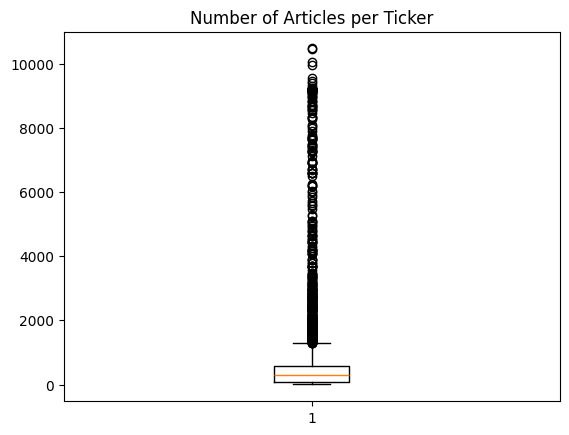

In [5]:
plt.boxplot(ticker_n_articles.values())
plt.title("Number of Articles per Ticker")
plt.show()

25% : 85.0 75%: 572.0


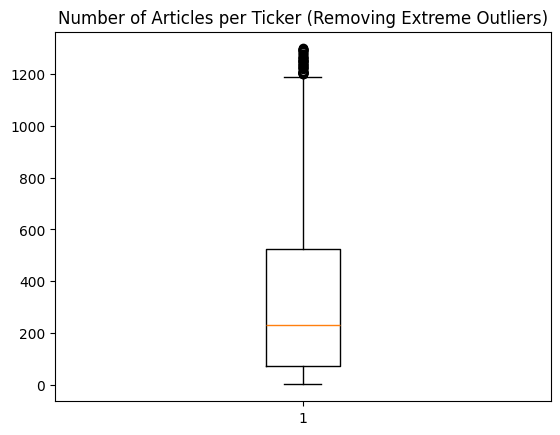

In [6]:
plt.boxplot(remove_outliers(list(ticker_n_articles.values())))
plt.title("Number of Articles per Ticker (Removing Extreme Outliers)")
plt.show()

## K tickers with most and least count

In [7]:
def remove_jsonl_from_ticker(ticker):
    ticker = ticker.replace(".jsonl", '')
    return ticker

In [10]:
k = 20
ticker_n_articles = dict(sorted(ticker_n_articles.items(), key=lambda item: item[1],  reverse=True))
top_k_tickers  = list(ticker_n_articles.keys())[:k]
bottom_k_tickers = list(ticker_n_articles.keys())[-k:]
# top_k_tickers = [remove_jsonl_from_ticker(ticker) for ticker in top_k_tickers]
# bottom_k_tickers = [remove_jsonl_from_ticker(ticker) for ticker in bottom_k_tickers]

100%|██████████| 20/20 [00:00<00:00, 167103.75it/s]


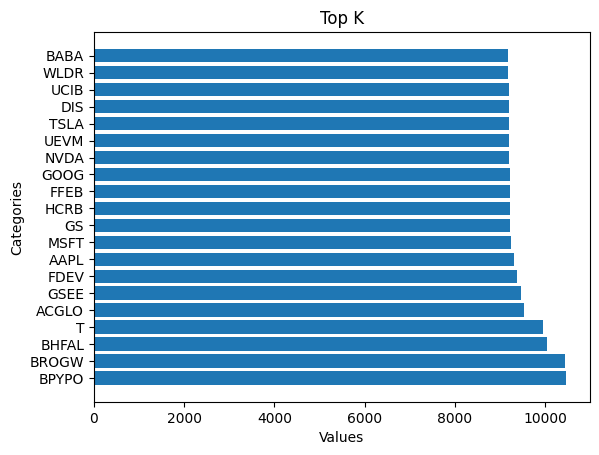

In [11]:
# top K
top_k_values= []
for ticker in tqdm(top_k_tickers):
    top_k_values.append(ticker_n_articles[ticker])

plt.barh([remove_jsonl_from_ticker(ticker) for ticker in top_k_tickers], top_k_values)
plt.xlabel("Values")
plt.ylabel("Categories")
plt.title("Top K")
plt.show()

100%|██████████| 20/20 [00:00<00:00, 317750.30it/s]


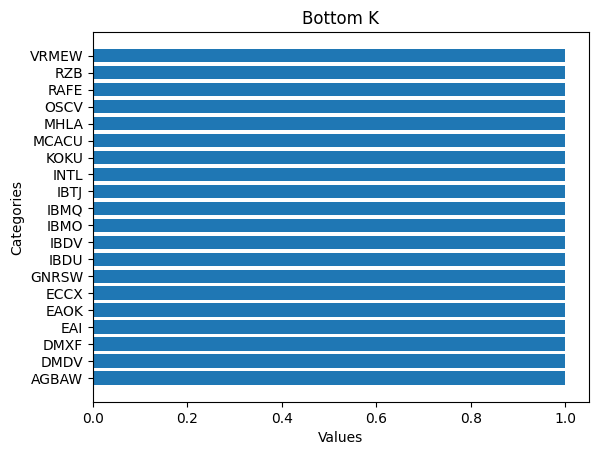

In [12]:
# bottom K
bottom_k_values= []
for ticker in tqdm(bottom_k_tickers):
    bottom_k_values.append(ticker_n_articles[ticker])

plt.barh([remove_jsonl_from_ticker(ticker) for ticker in bottom_k_tickers], bottom_k_values)
plt.xlabel("Values")
plt.ylabel("Categories")
plt.title("Bottom K")
plt.show()

## No. of News articles over years for Top K Tickers

In [13]:
df_date_n_articles = {"date": [], "ticker":[]}
for ticker in tqdm(top_k_tickers):
    ticker_ = remove_jsonl_from_ticker(ticker)
    data = read_jsonl(os.path.join(config["NEWS_FOLDER"], ticker))
    for article in data:
        df_date_n_articles["date"].append(article["Date"])
        df_date_n_articles["ticker"].append(ticker_)
df_date_n_articles = pd.DataFrame(df_date_n_articles)


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


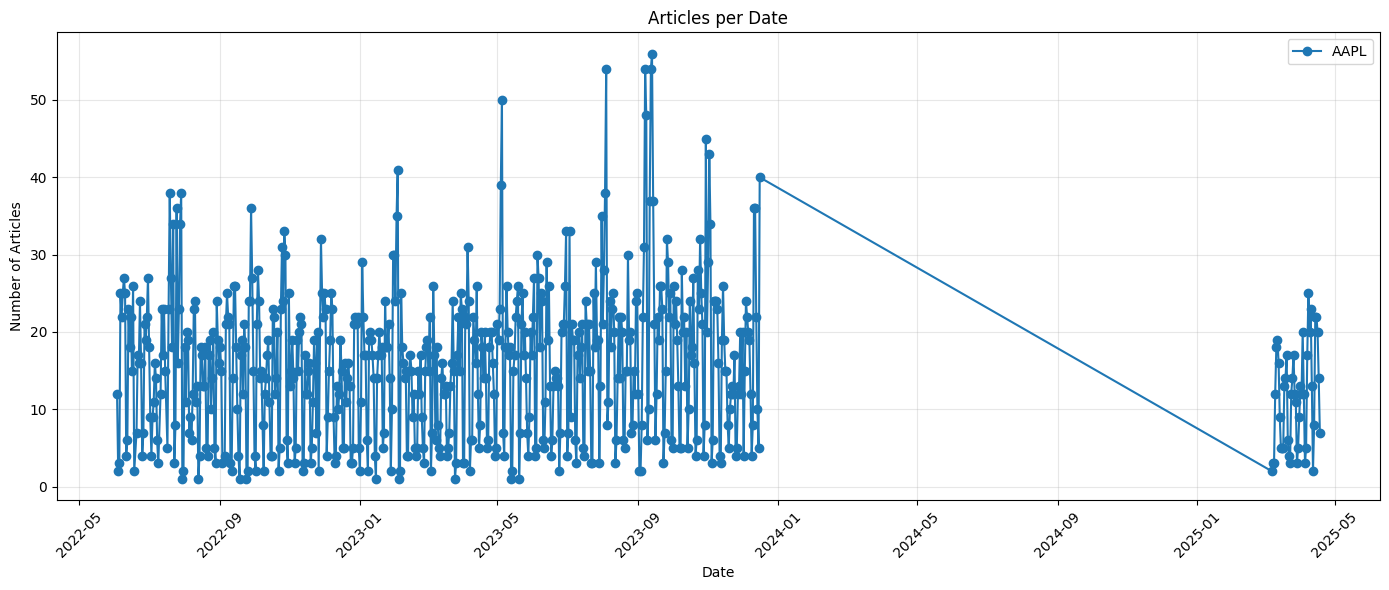

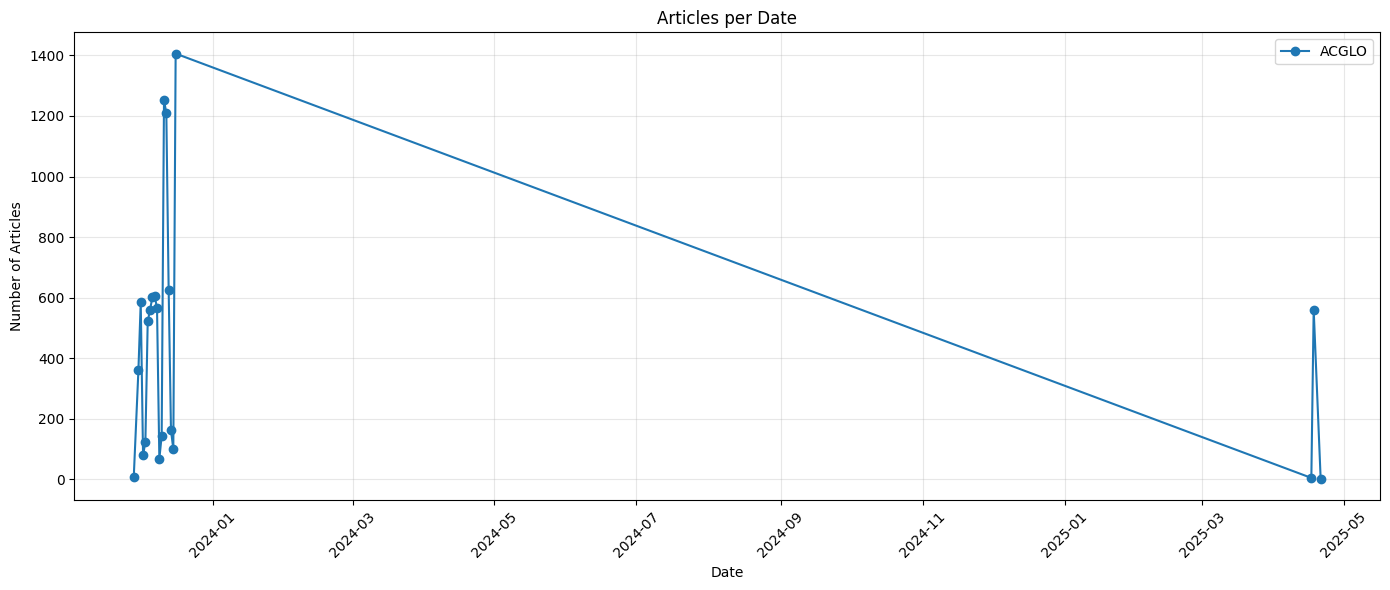

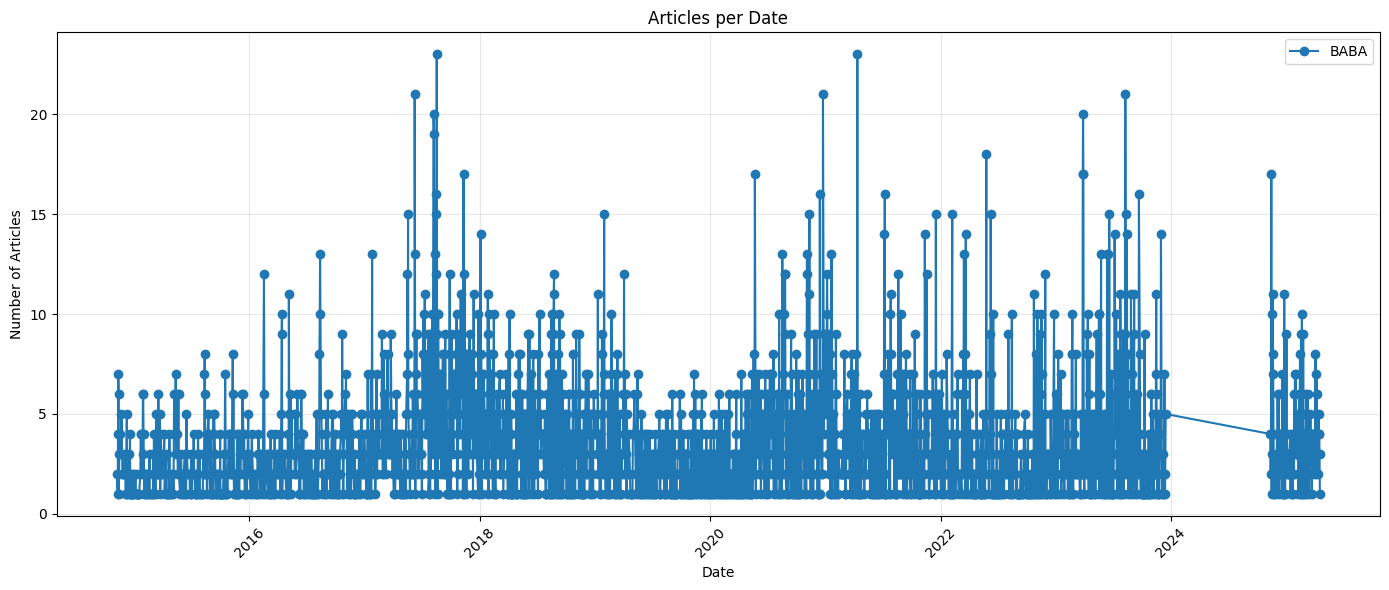

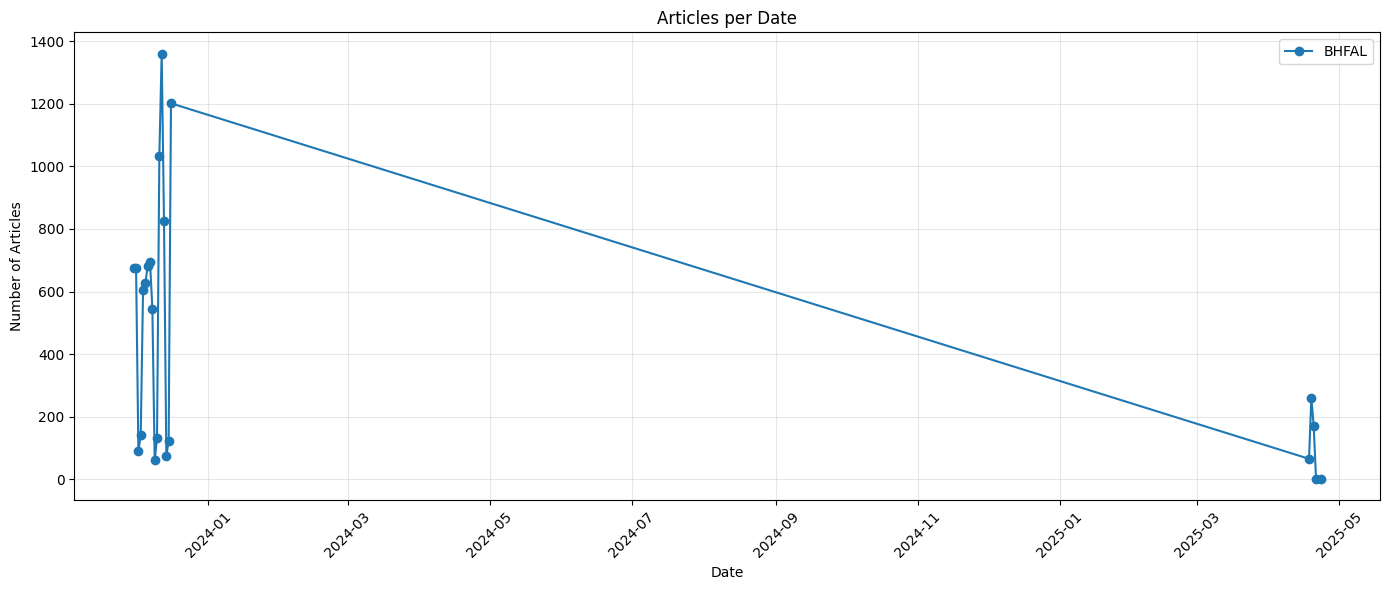

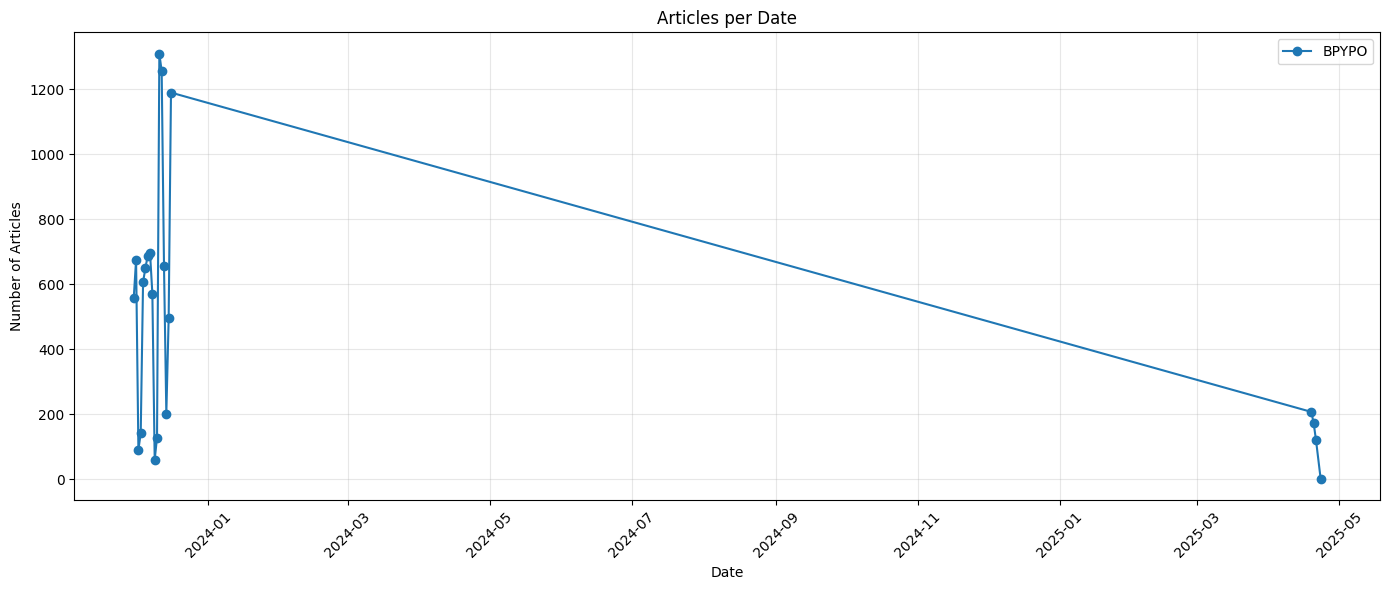

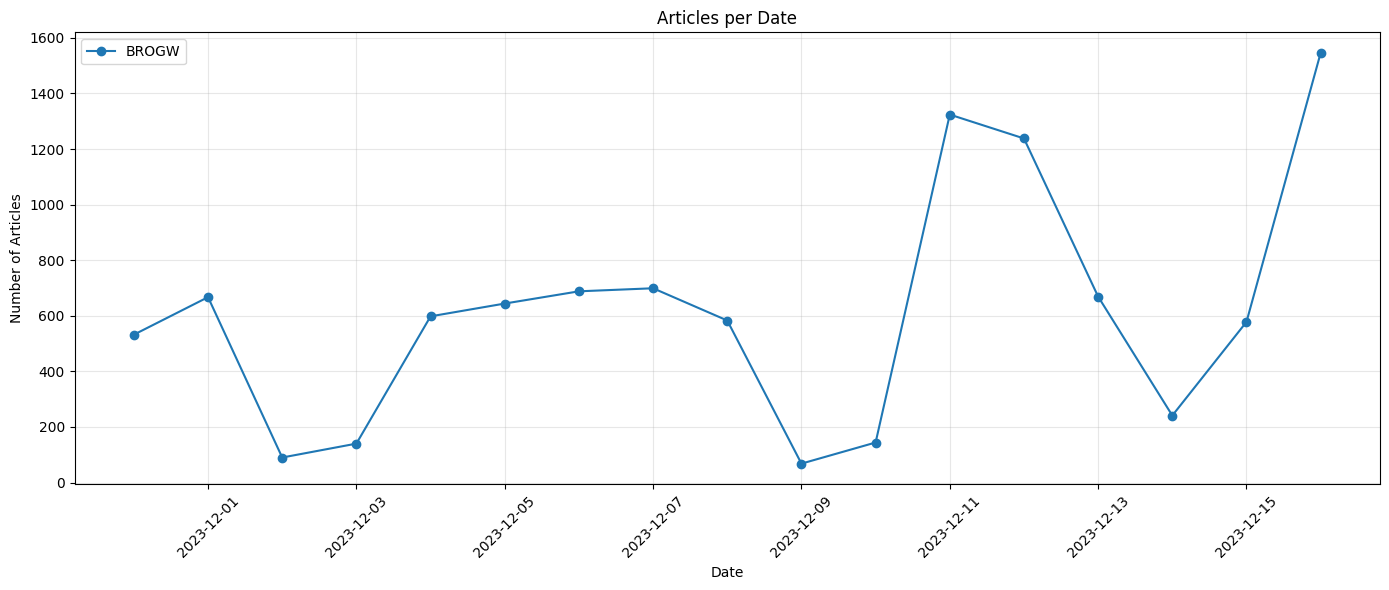

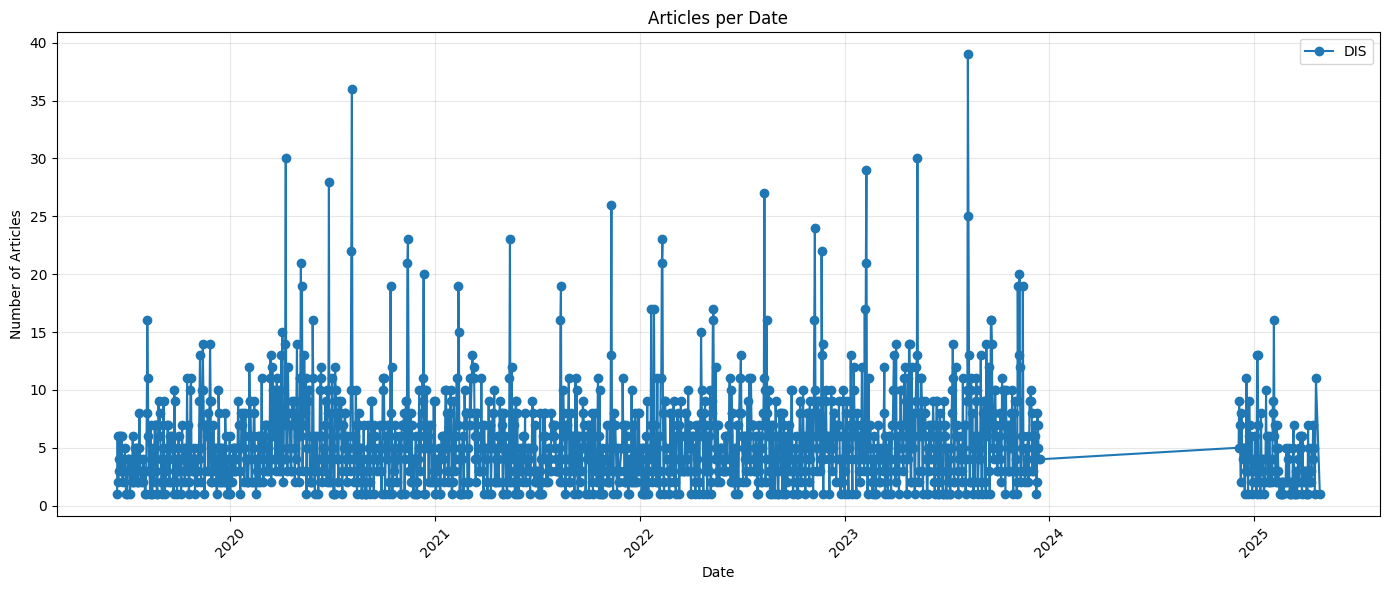

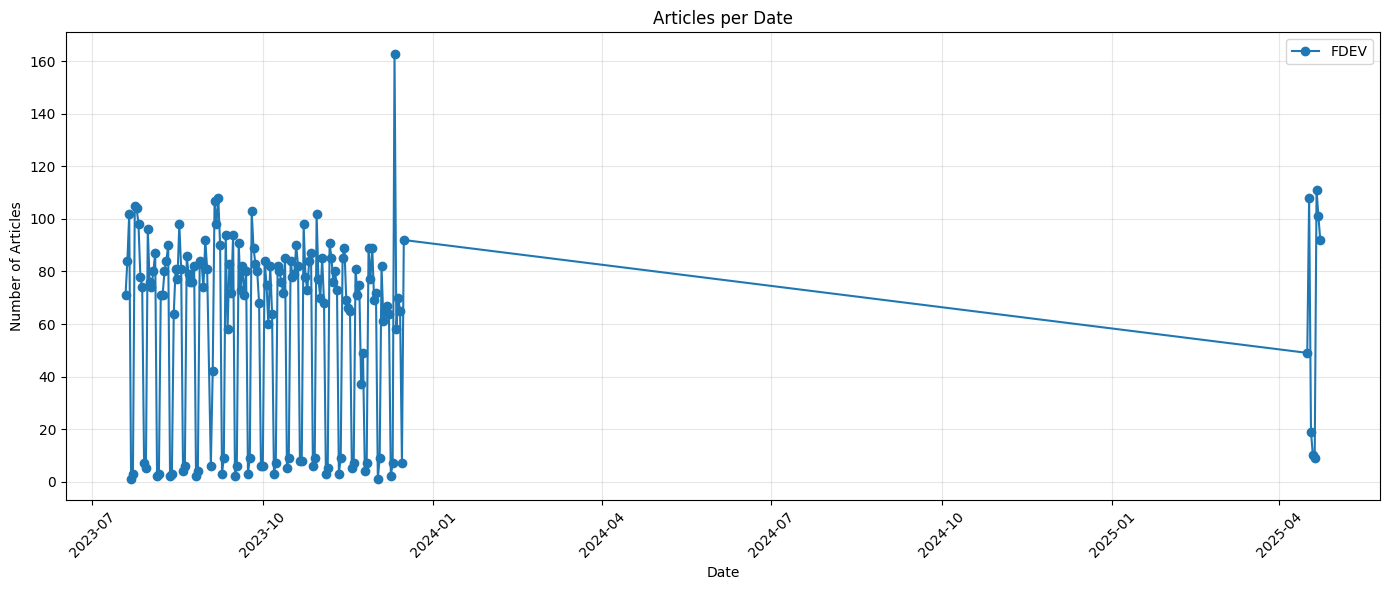

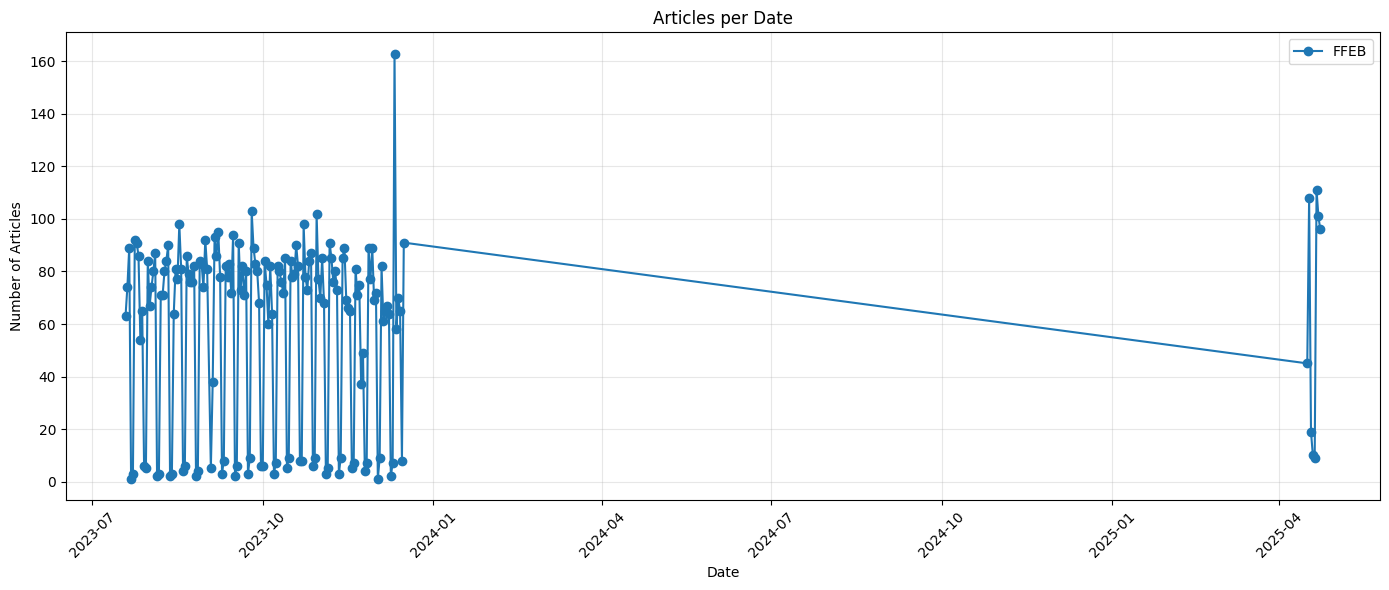

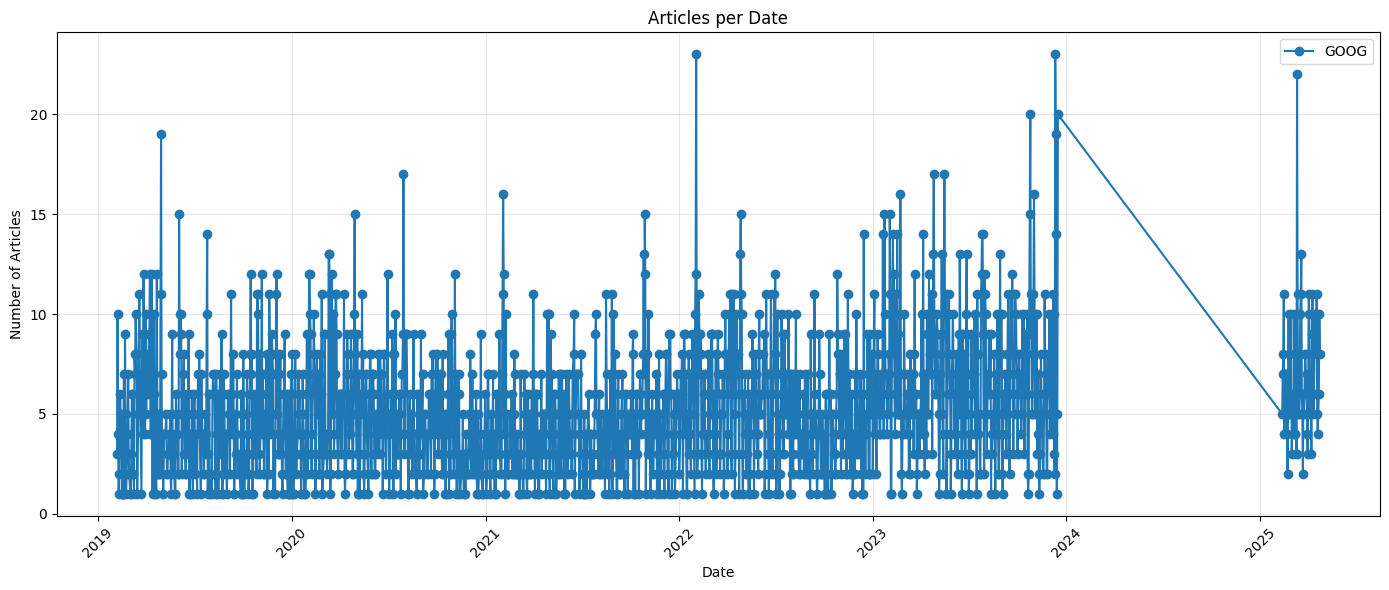

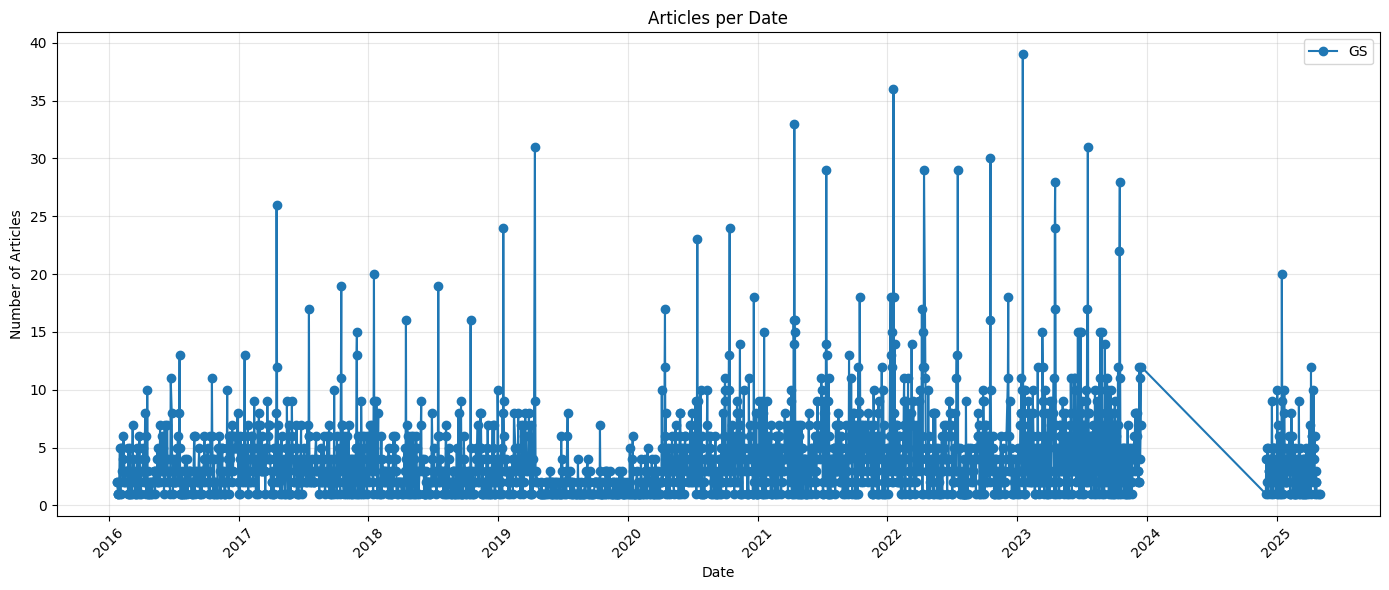

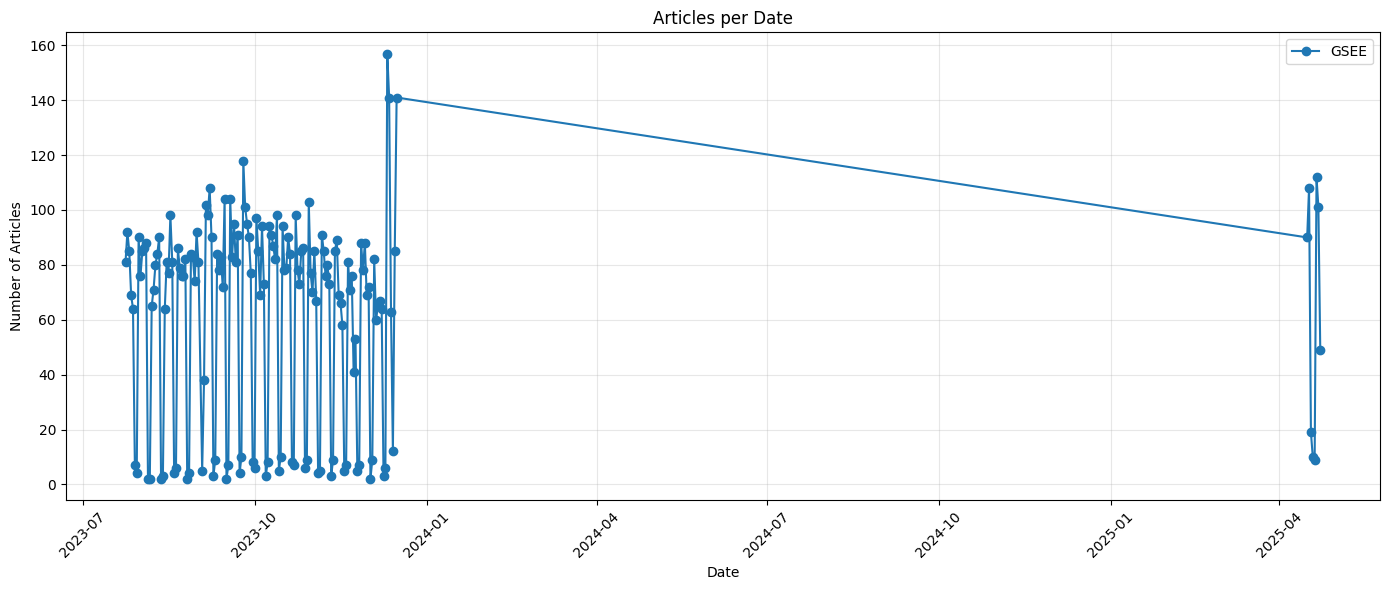

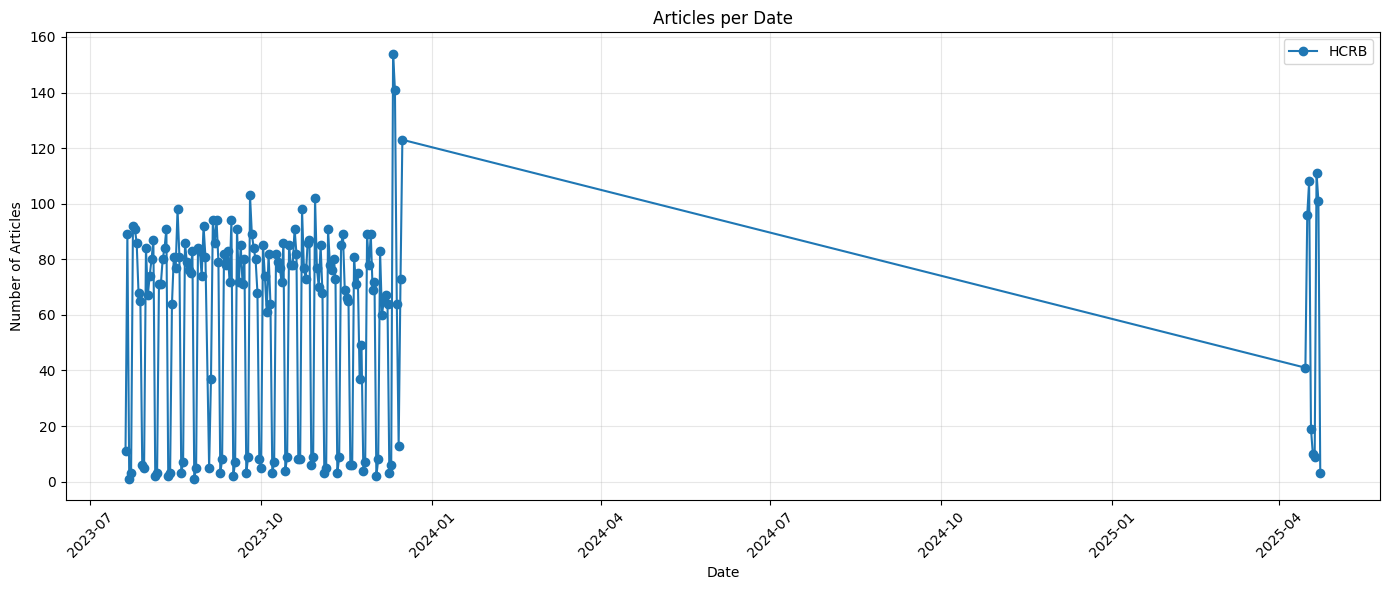

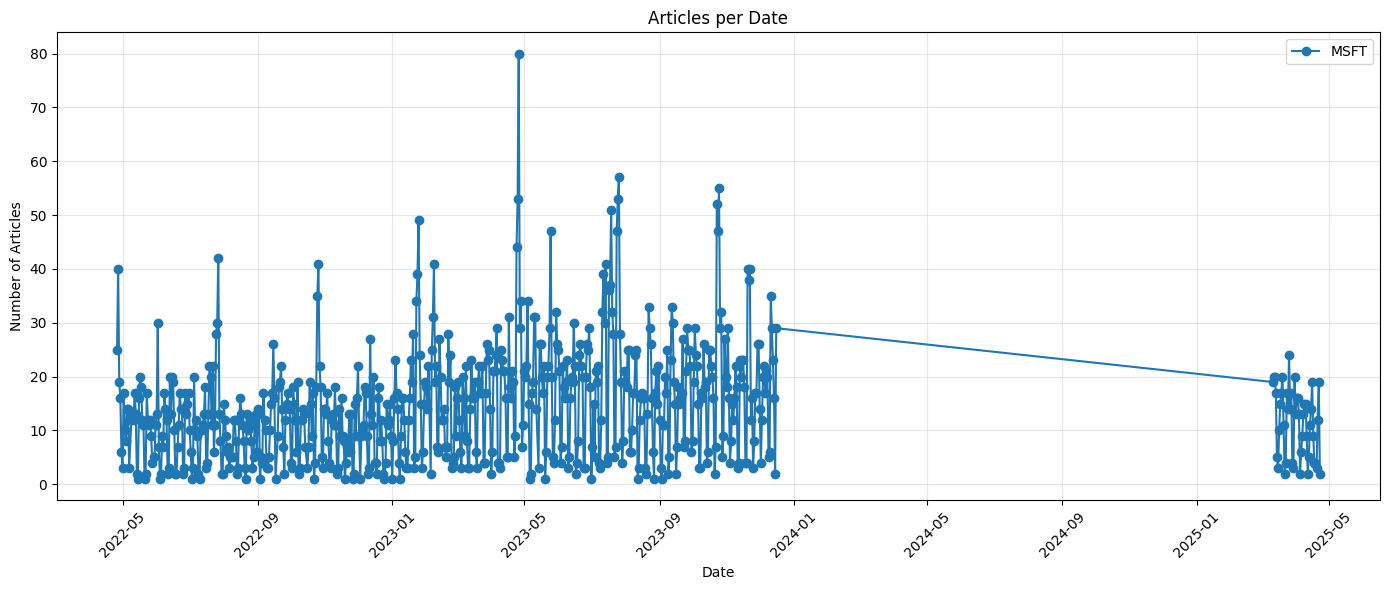

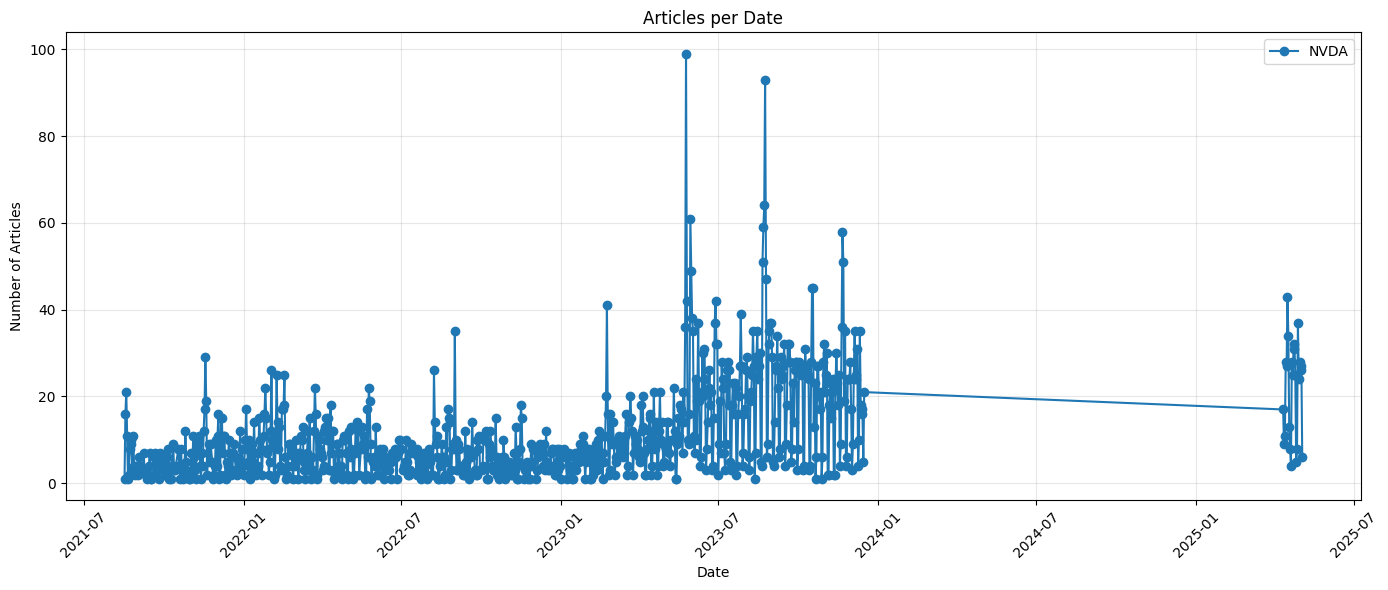

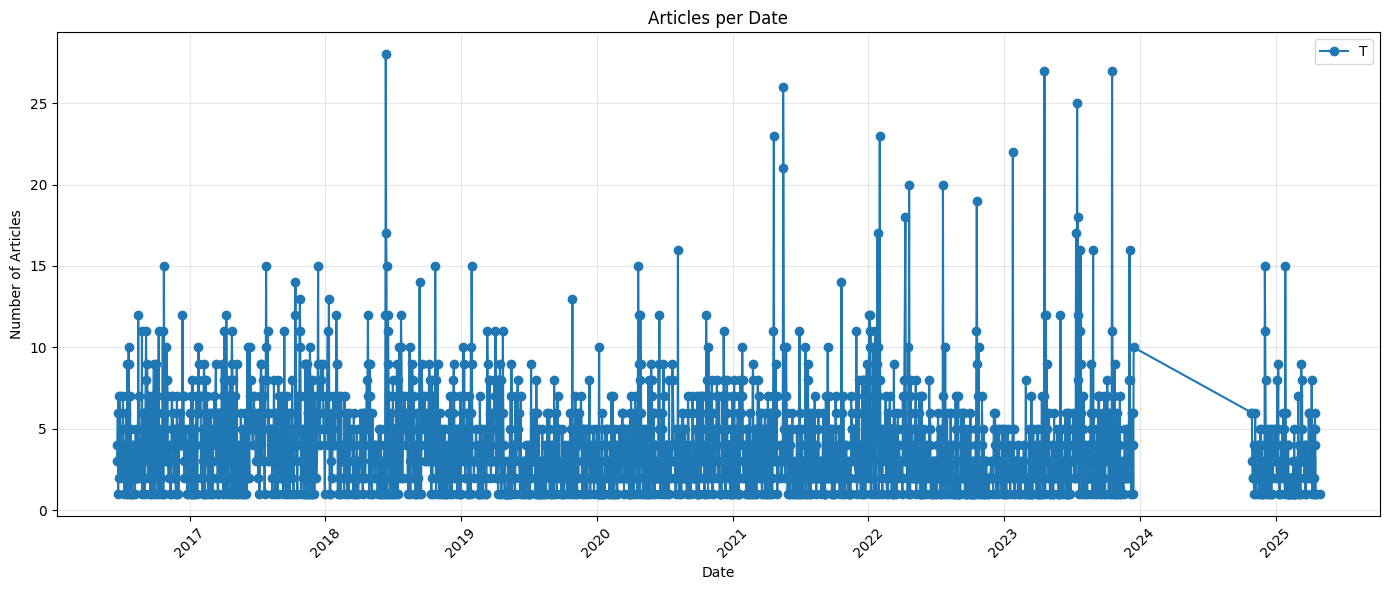

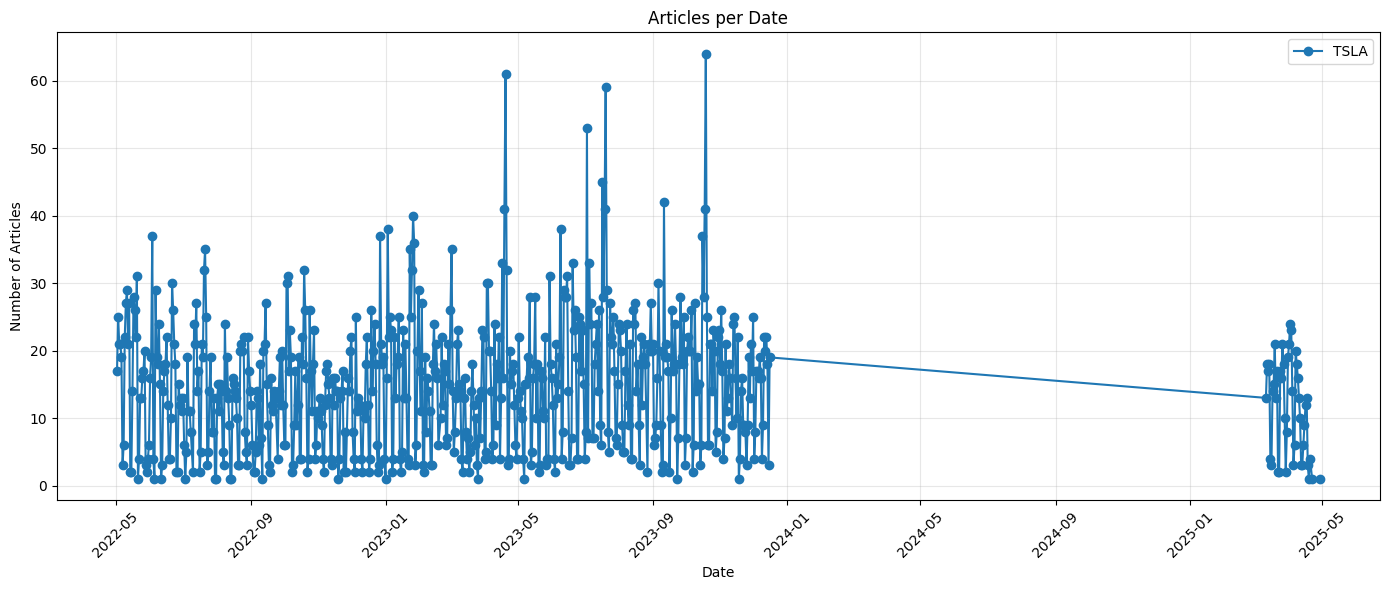

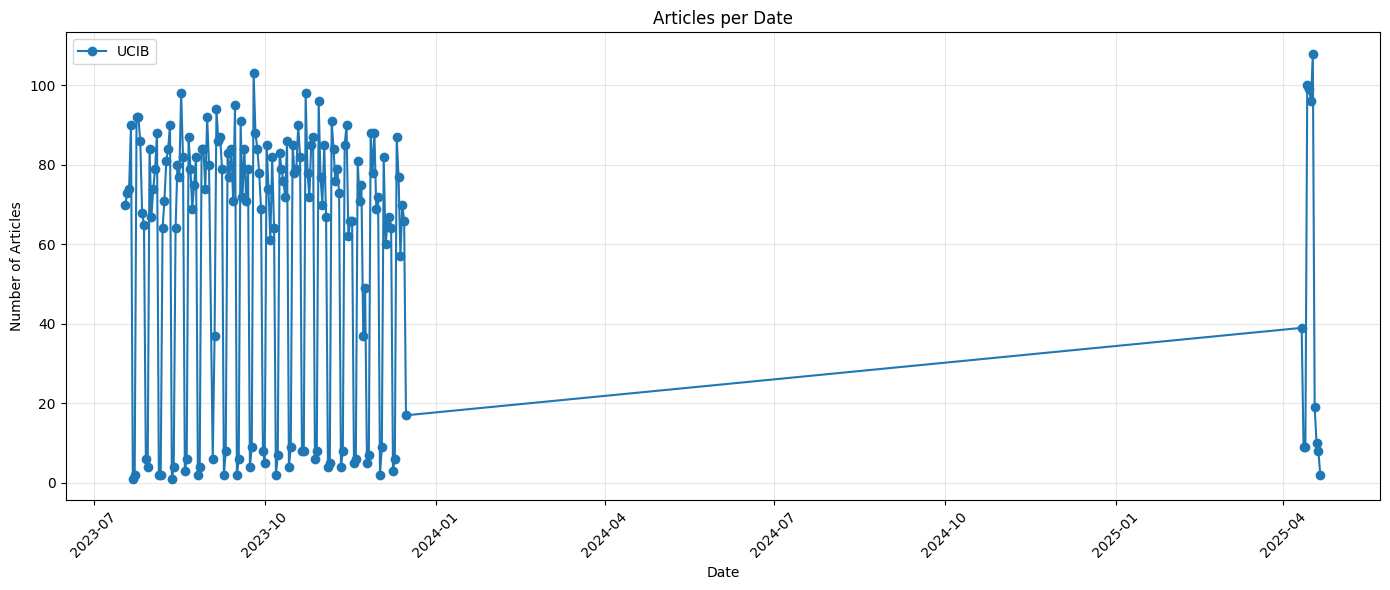

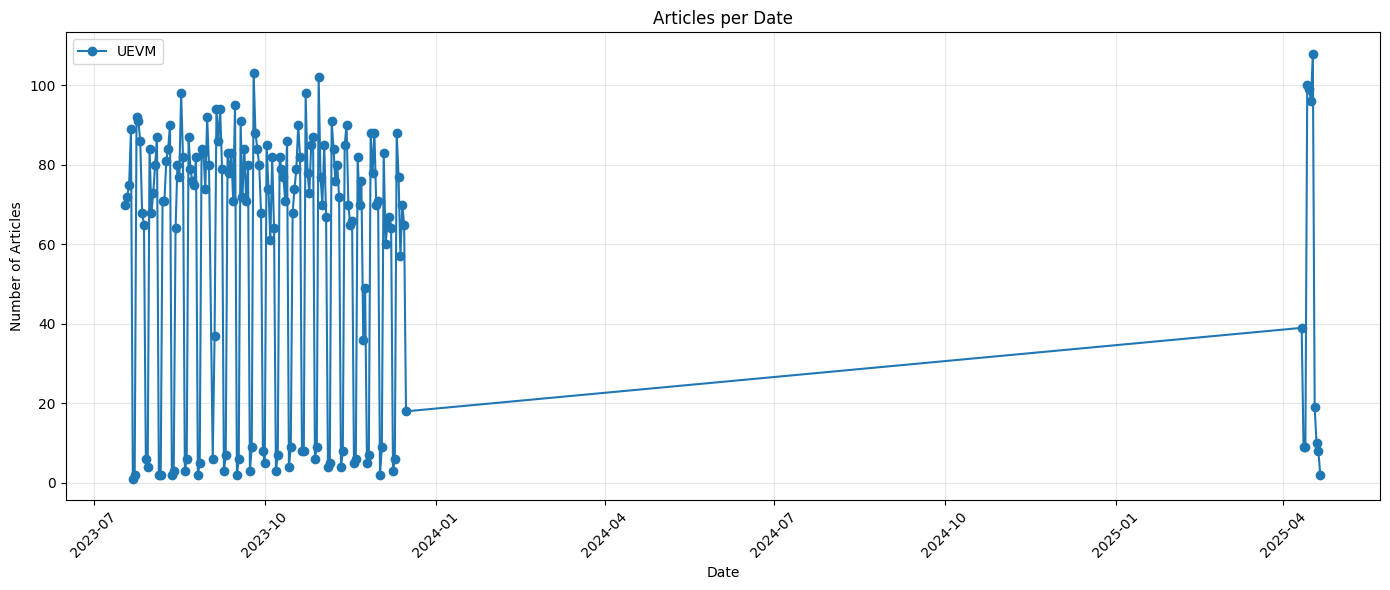

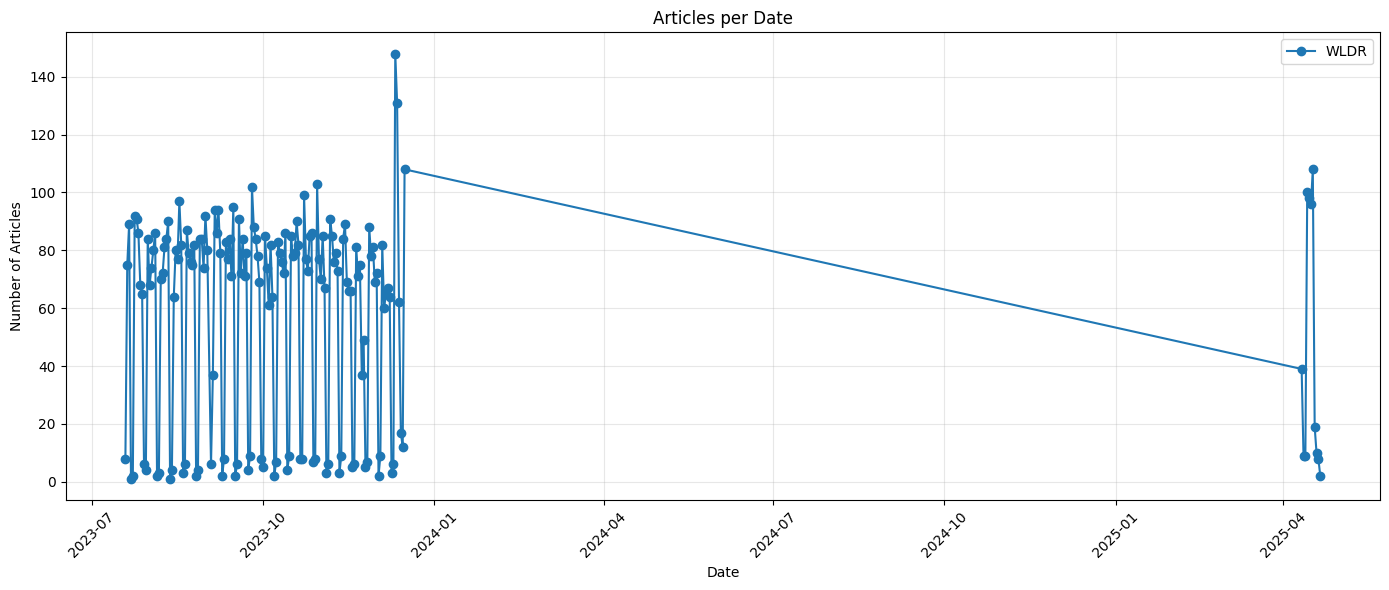

In [14]:
df_date_n_articles['date'] = pd.to_datetime(df_date_n_articles['date'])
date_counts = (
    df_date_n_articles
    .groupby(['ticker', 'date'])
    .size()
    .reset_index(name='freq')
)
tickers = sorted(date_counts['ticker'].unique())
tickers_per_plot = 1
n_plots = math.ceil(len(tickers) / tickers_per_plot)
for i in range(n_plots):
    plt.figure(figsize=(14, 6))

    batch = tickers[i * tickers_per_plot:(i + 1) * tickers_per_plot]

    for ticker in batch:
        df_t = date_counts[date_counts['ticker'] == ticker]

        plt.plot(
            df_t['date'],
            df_t['freq'],
            marker='o',
            label=ticker
        )

    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.title(f'Articles per Date')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Sector Analysis

In [30]:
data_dictionary_df = pd.read_csv(config["DATA_DICTIONARY"])
data_dictionary_df["Sector"] = data_dictionary_df["Sector"].fillna("N/A")
ticker_to_sector = data_dictionary_df.set_index("stock_name")["Sector"].to_dict()

### Number of tickers in each sector

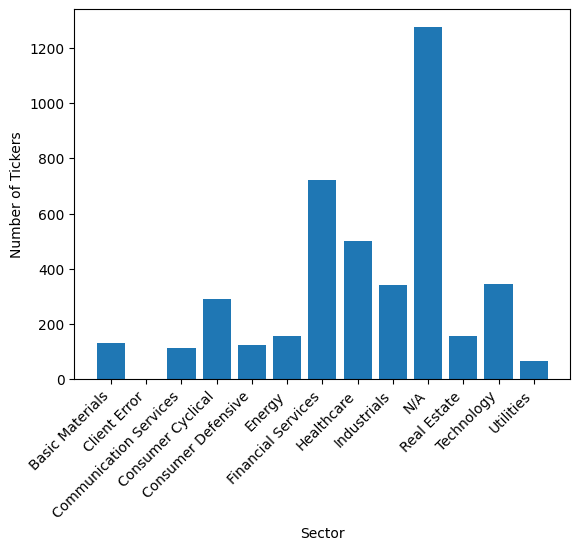

In [32]:
sector_counts = Counter(ticker_to_sector.values())
plt.bar(sector_counts.keys(),sector_counts.values())
plt.xlabel("Sector")
plt.ylabel("Number of Tickers")
plt.xticks(rotation=45, ha='right')
plt.show()

### Number of Articles in Each sector

In [45]:
no_of_news_articles_sectors = defaultdict(int)
for ticker, n_articles in zip(ticker_n_articles.keys(), ticker_n_articles.values()):
    if remove_jsonl_from_ticker(ticker).lower() in ticker_to_sector:
        no_of_news_articles_sectors[ticker_to_sector[remove_jsonl_from_ticker(ticker).lower()]] += n_articles


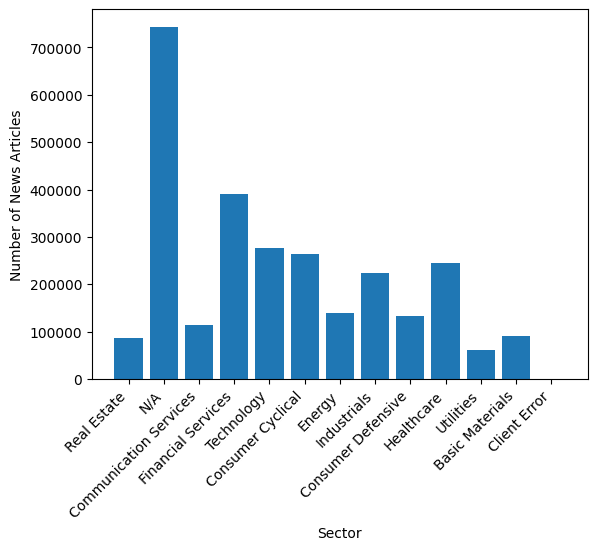

In [50]:
plt.bar(no_of_news_articles_sectors.keys(),no_of_news_articles_sectors.values())
plt.xlabel("Sector")
plt.ylabel("Number of News Articles")
plt.xticks(rotation=45, ha='right')
plt.show()

### Number of articles over years

In [56]:
df_date_n_articles_sector = {"date": [], "sector":[]}
for ticker in tqdm(list_of_tickers):
    ticker_ = remove_jsonl_from_ticker(ticker)
    if ticker_.lower() not in ticker_to_sector:
        continue
    data = read_jsonl(os.path.join(config["NEWS_FOLDER"], ticker))
    for article in data:
        df_date_n_articles_sector["date"].append(article["Date"])
        df_date_n_articles_sector["sector"].append(ticker_to_sector[ticker_.lower()])
df_date_n_articles_sector = pd.DataFrame(df_date_n_articles_sector)

100%|██████████| 4694/4694 [01:04<00:00, 73.19it/s] 


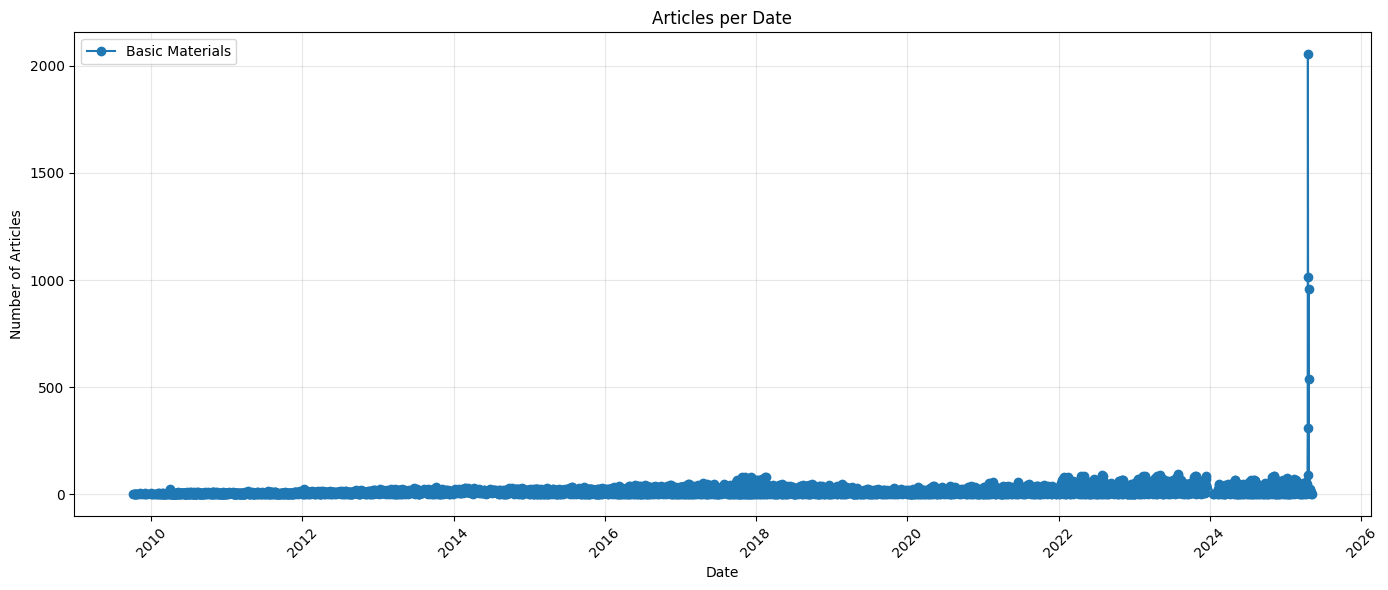

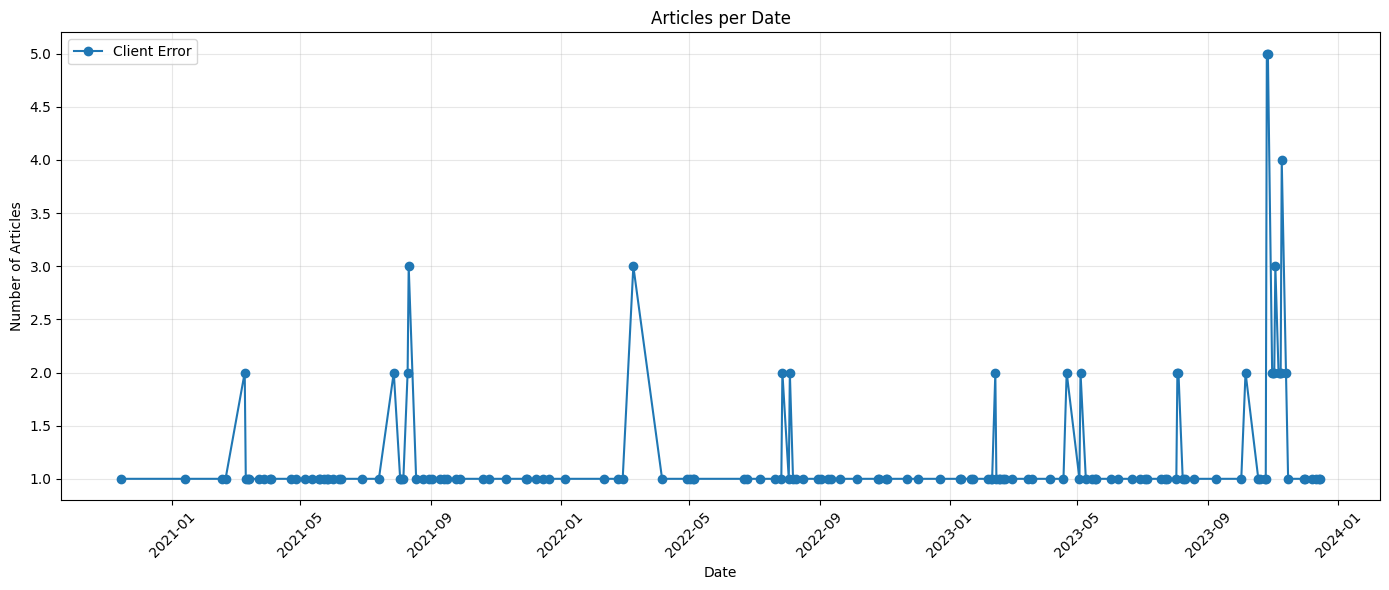

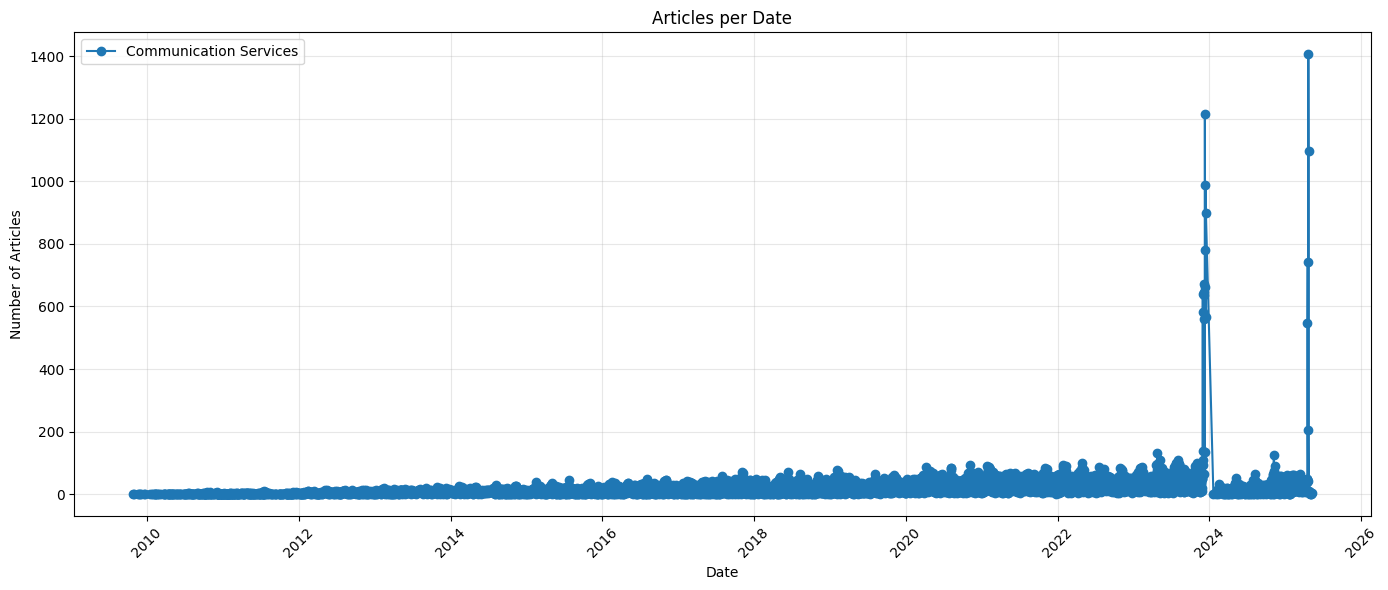

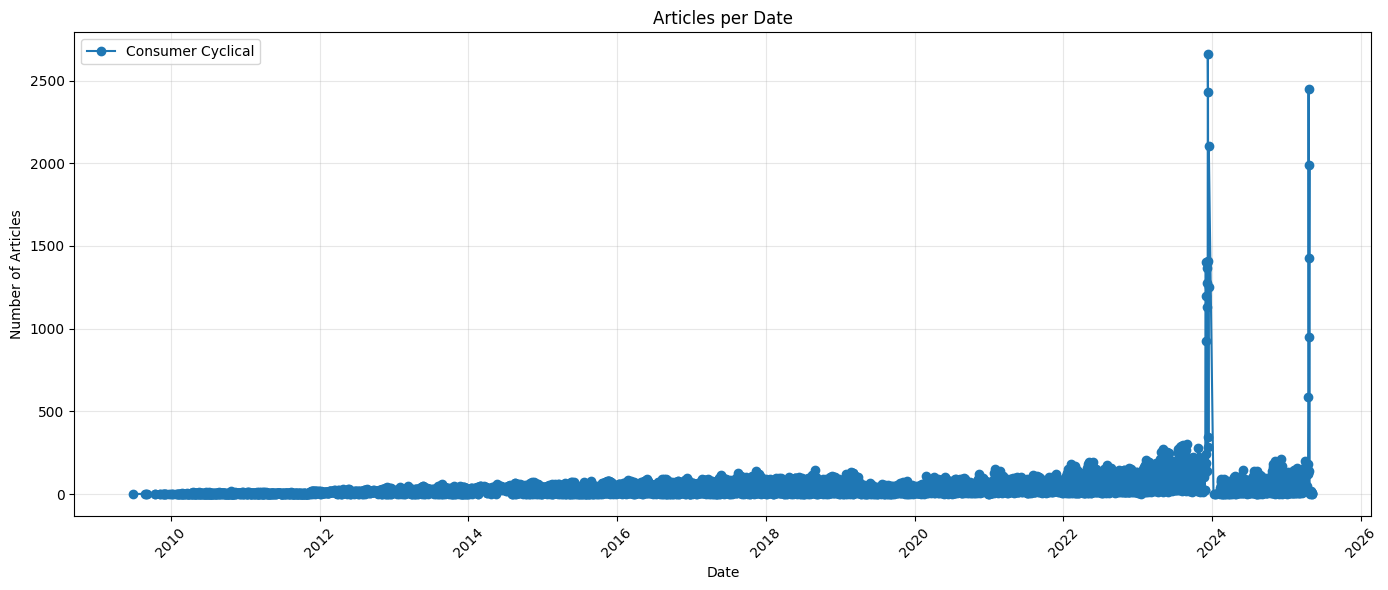

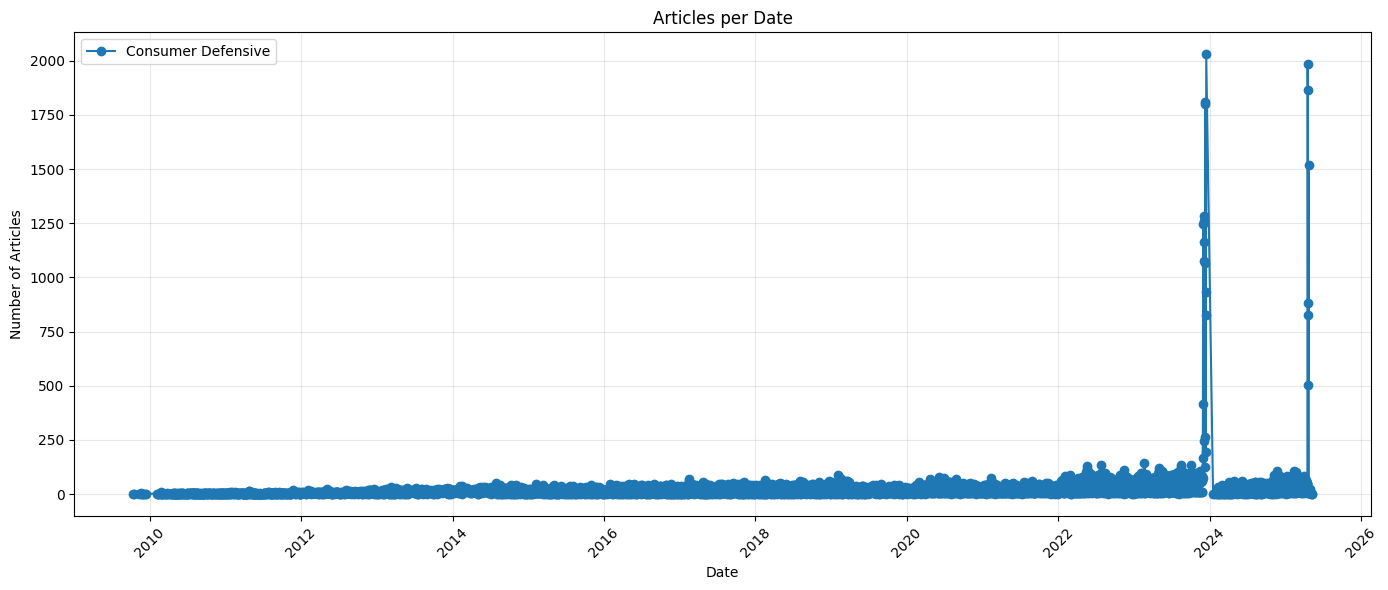

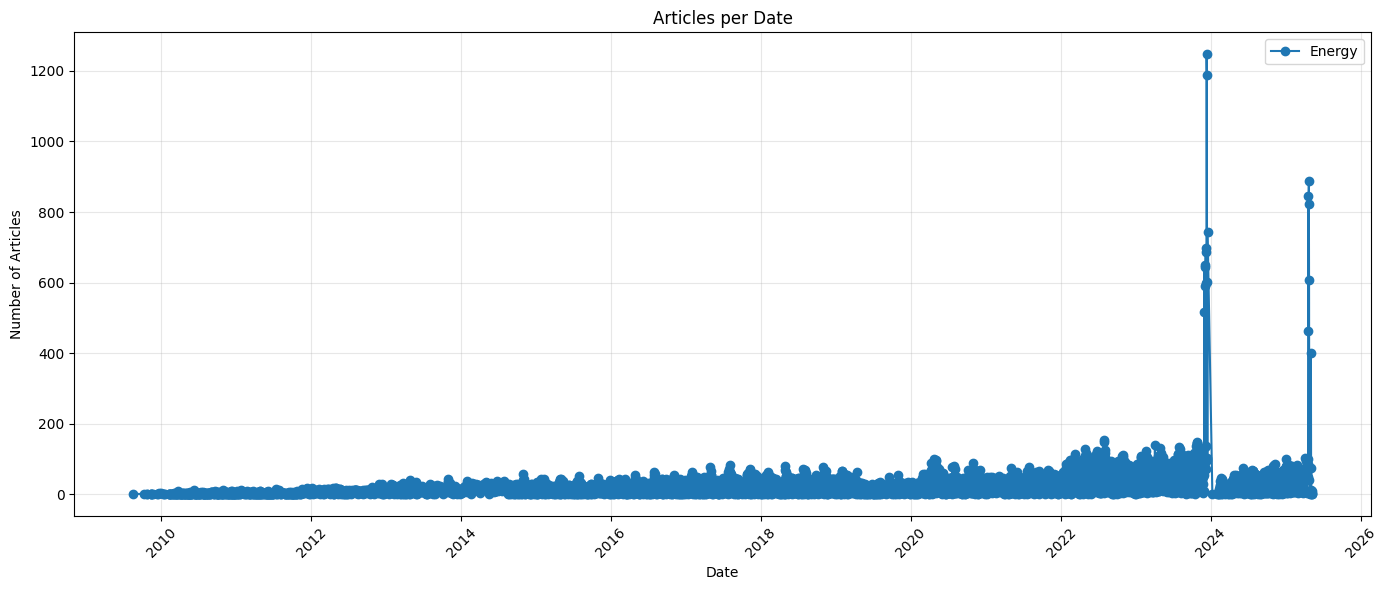

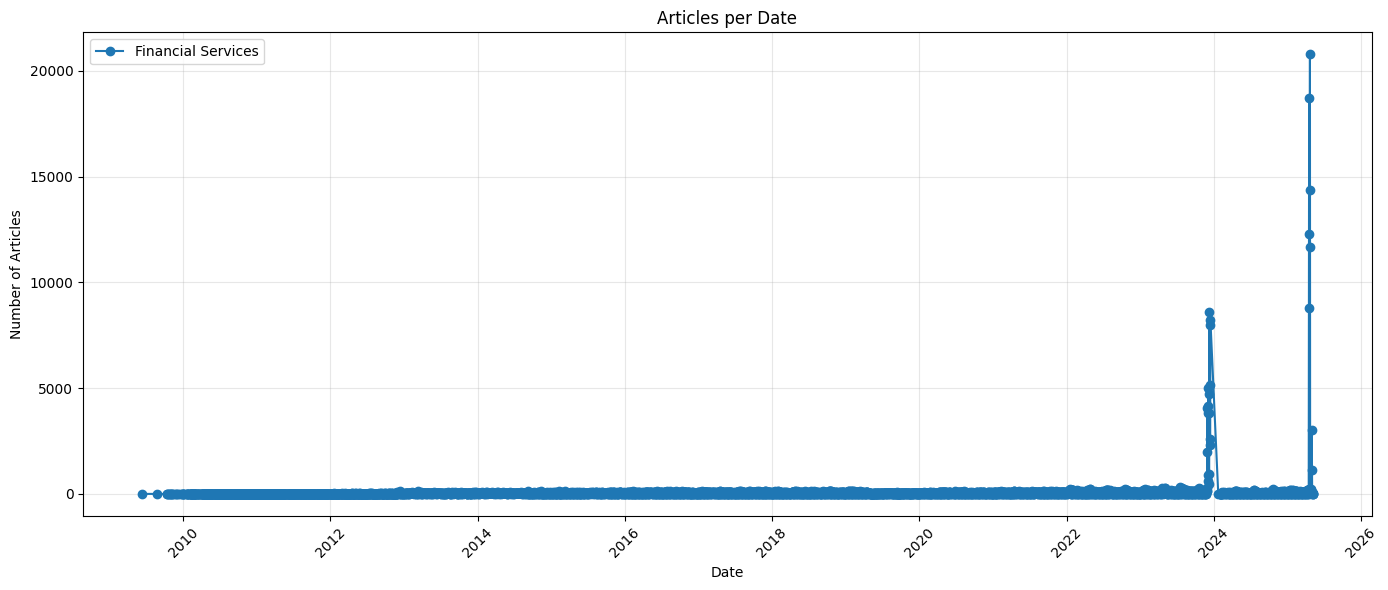

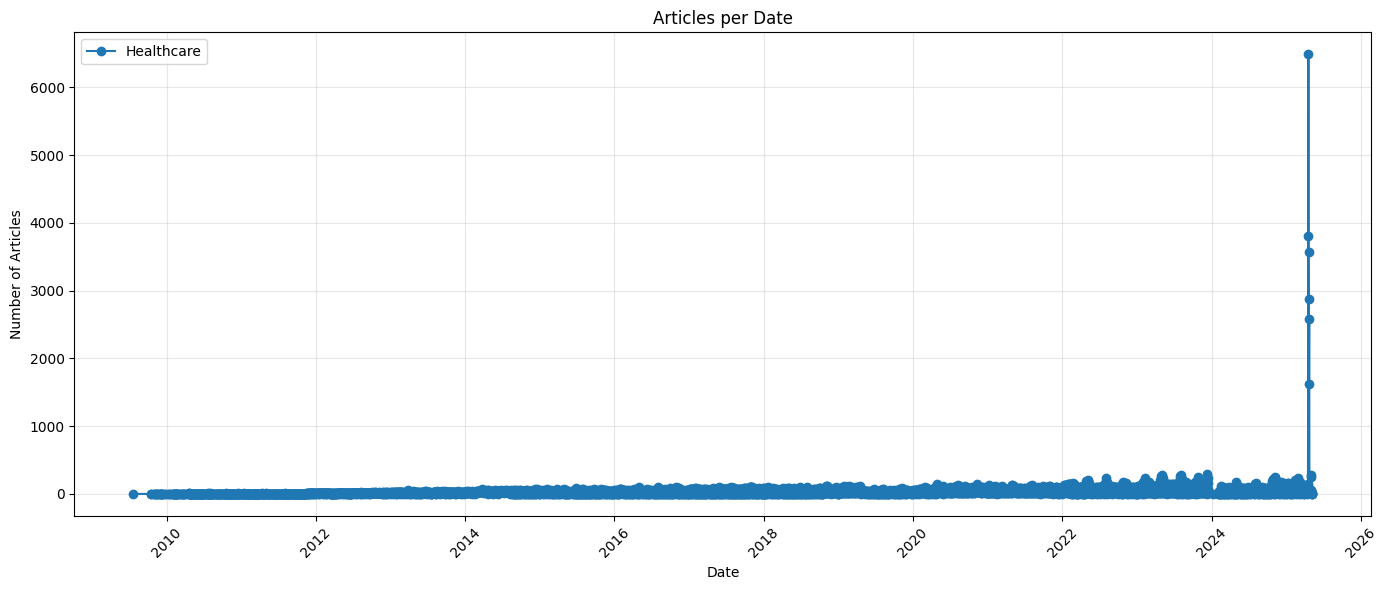

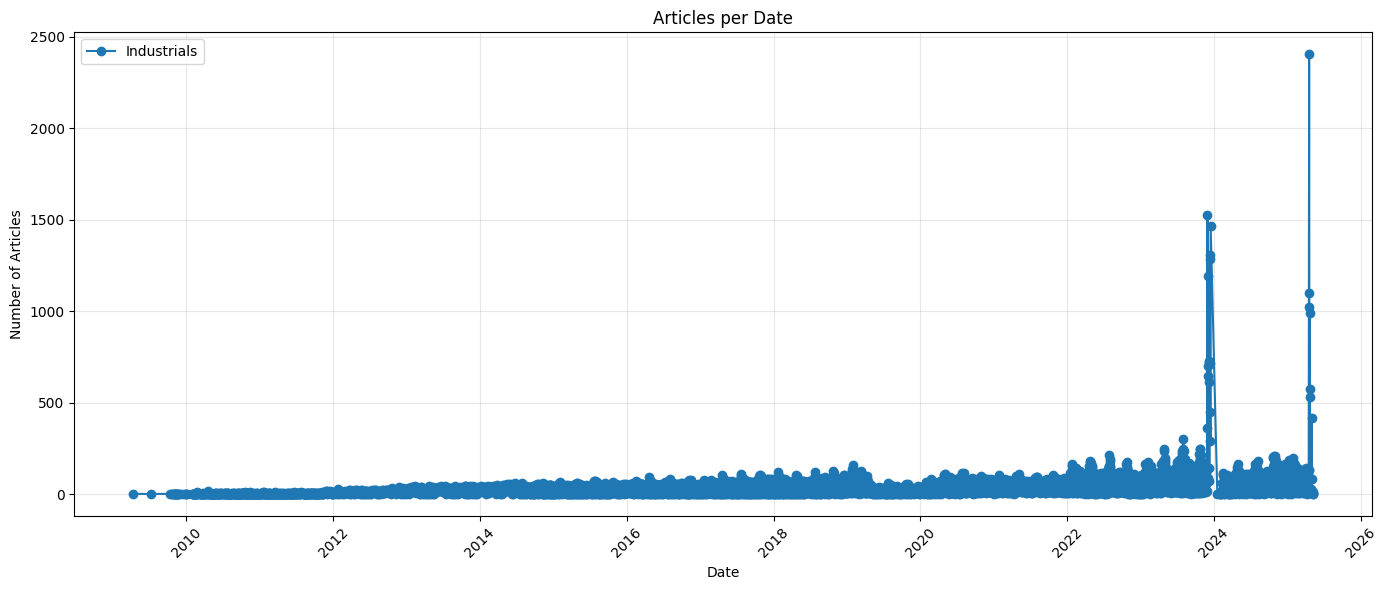

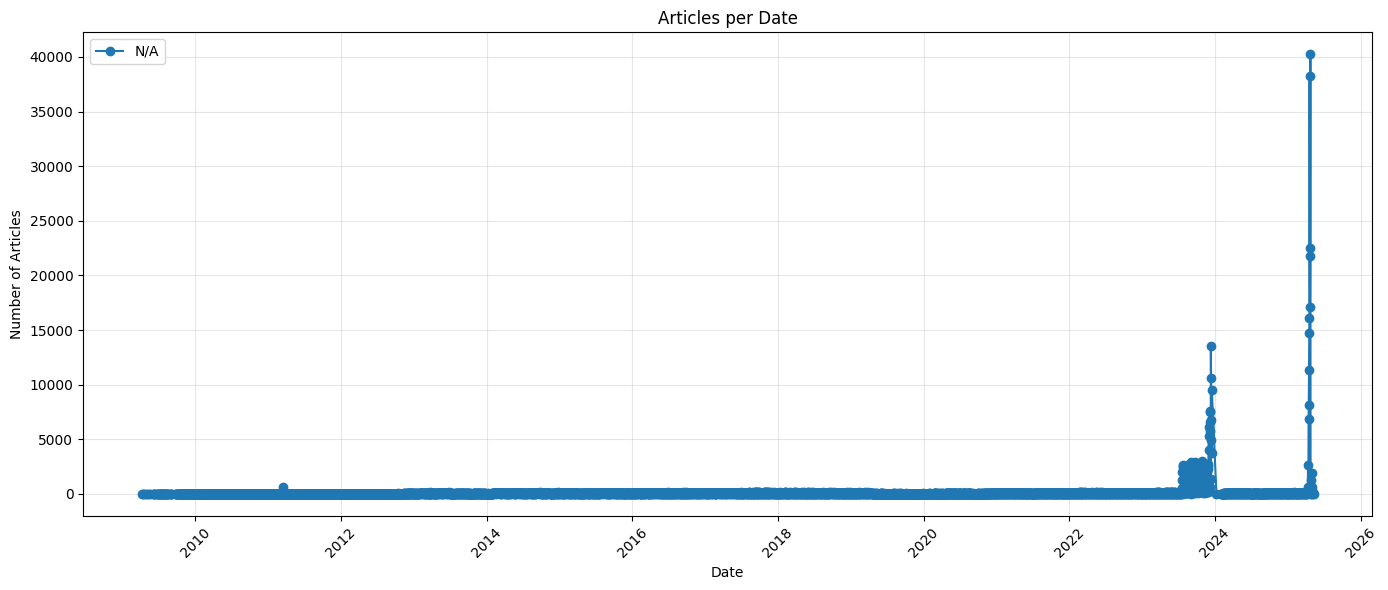

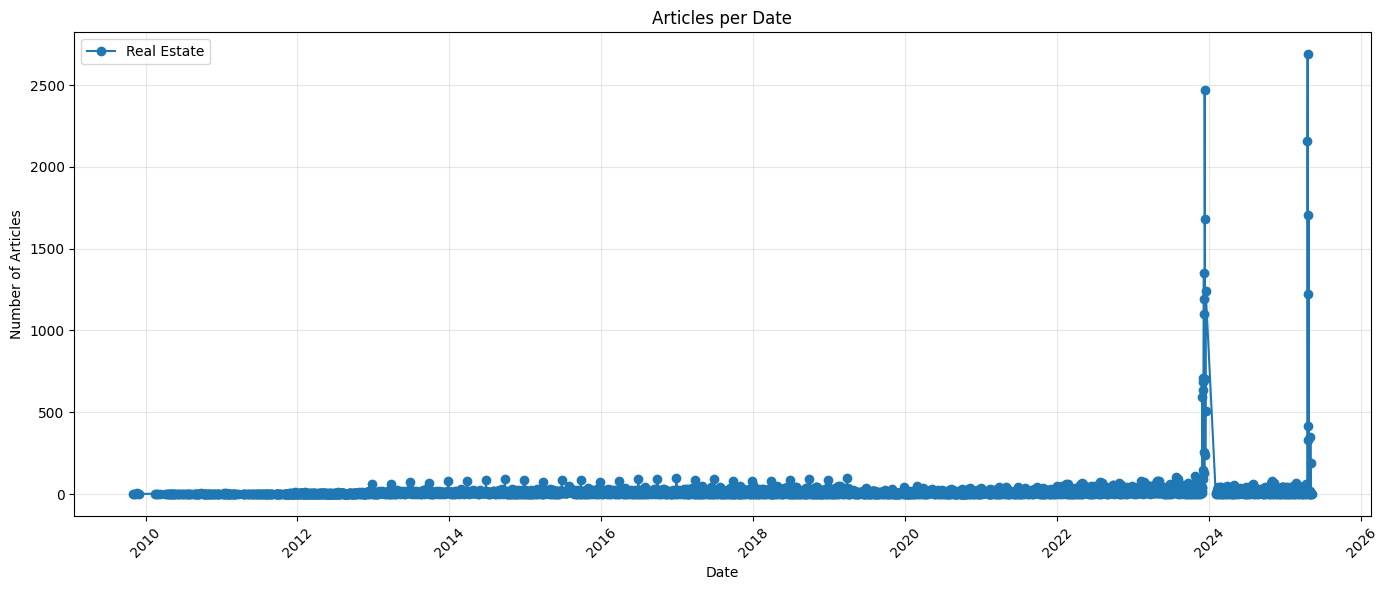

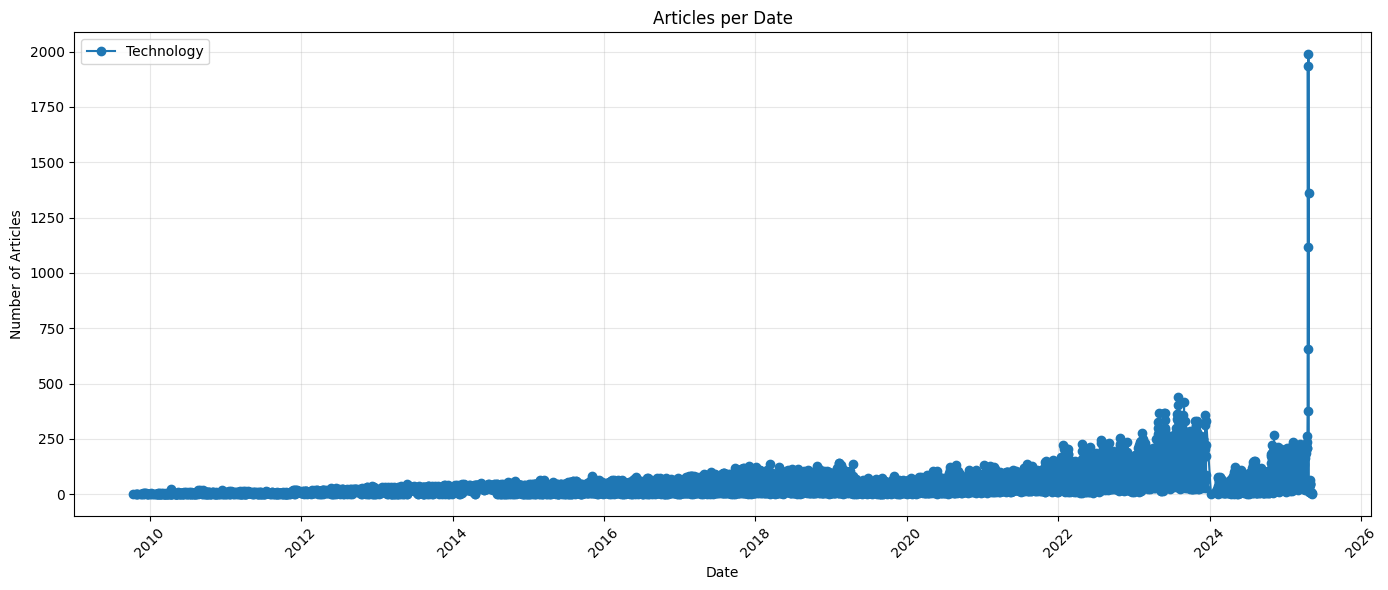

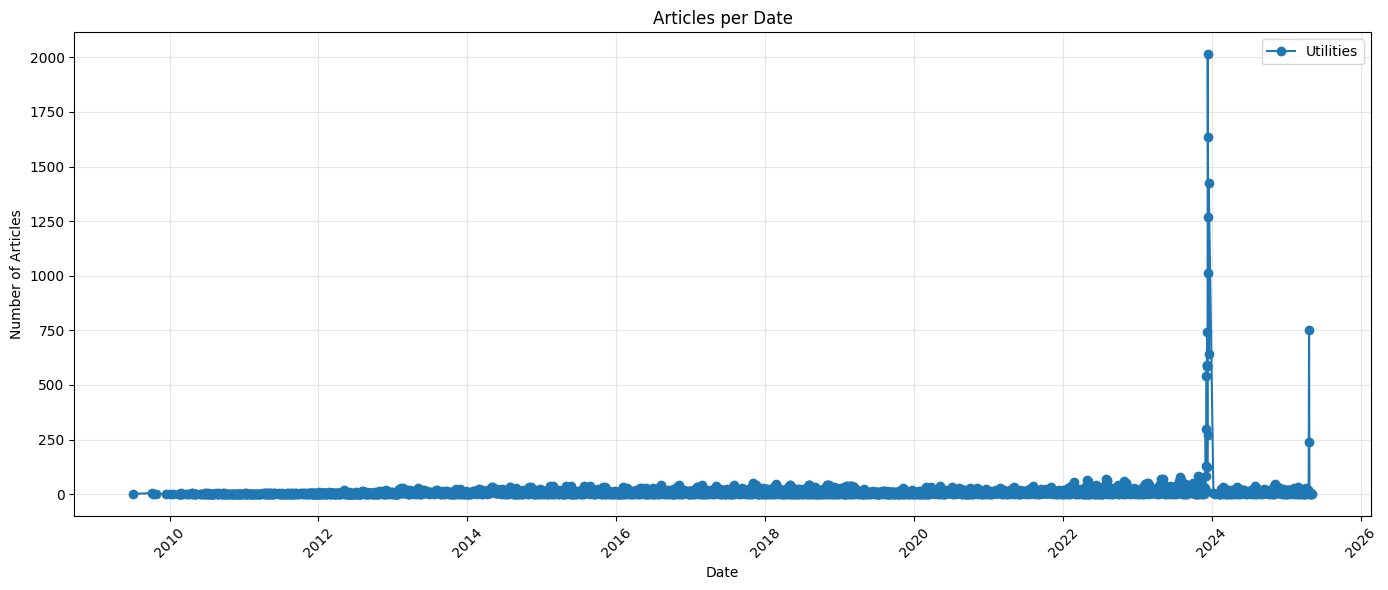

In [60]:
df_date_n_articles_sector['date'] = pd.to_datetime(df_date_n_articles_sector['date'])
date_counts = (
    df_date_n_articles_sector
    .groupby(['sector', 'date'])
    .size()
    .reset_index(name='freq')
)
sectors = sorted(date_counts['sector'].unique())
sectors_per_plot = 1
n_plots = math.ceil(len(sectors) / sectors_per_plot)
for i in range(n_plots):
    plt.figure(figsize=(14, 6))

    batch = sectors[i * sectors_per_plot:(i + 1) * sectors_per_plot]

    for sector in batch:
        df_t = date_counts[date_counts['sector'] == sector]

        plt.plot(
            df_t['date'],
            df_t['freq'],
            marker='o',
            label=sector
        )

    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.title(f'Articles per Date')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Selecting K worthy stokes for model training

In [79]:
TOP_K = 20

W_MIN = 360*10        # minimum trainable window (days)
C_MIN = 0.25       # min coverage inside window
G_MAX = 14         # max allowed p90 gap (days)

C_TARGET = 0.40
G_TARGET = 5
G90_TARGET = 14
V_TARGET = 1000
W_TARGET = 365


In [80]:
def build_daily_series(df):
    daily = (
        df.groupby("date")
          .size()
          .rename("count")
          .to_frame()
    )

    full_index = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
    daily = daily.reindex(full_index, fill_value=0)
    daily.index.name = "date"
    return daily


In [81]:
def compute_gap_metrics(active_dates):
    if len(active_dates) < 2:
        return np.inf, np.inf

    gaps = np.diff(active_dates).astype("timedelta64[D]").astype(int)
    return gaps.mean(), np.percentile(gaps, 90)


In [82]:
def compute_entropy(counts):
    probs = counts[counts > 0] / counts.sum()
    entropy = -np.sum(probs * np.log(probs))
    return entropy / np.log(len(probs)) if len(probs) > 1 else 0.0


In [83]:
def find_best_window(daily, window_min=W_MIN):
    best = None

    active_days = daily[daily["count"] > 0]

    for start in active_days.index:
        end = start + timedelta(days=window_min)

        if end > daily.index.max():
            break

        window = daily.loc[start:end]
        coverage = (window["count"] > 0).mean()

        active = window[window["count"] > 0]
        if len(active) < 2:
            continue

        avg_gap, p90_gap = compute_gap_metrics(active.index.values)

        if coverage >= C_MIN and p90_gap <= G_MAX:
            quality = (
                0.4 * coverage +
                0.3 * (1 - avg_gap / G_MAX) +
                0.2 * compute_entropy(window["count"]) +
                0.1 * math.log(window["count"].sum() + 1)
            )

            if best is None or quality > best["quality"]:
                best = {
                    "start": start,
                    "end": end,
                    "quality": quality,
                    "window_days": (end - start).days
                }

    return best


In [84]:
def score_ticker(daily):
    total_days = len(daily)
    active_days = daily[daily["count"] > 0]

    if len(active_days) < 2:
        return None

    coverage_ratio = len(active_days) / total_days
    avg_gap, p90_gap = compute_gap_metrics(active_days.index.values)
    entropy = compute_entropy(daily["count"])
    total_articles = daily["count"].sum()

    window = find_best_window(daily)
    if window is None:
        return None

    # Normalized scores
    coverage_score = min(coverage_ratio / C_TARGET, 1)
    gap_score = np.exp(-avg_gap / G_TARGET)
    p90_gap_score = np.exp(-p90_gap / G90_TARGET)
    volume_score = min(np.log(total_articles + 1) / np.log(V_TARGET), 1)
    window_score = min(window["window_days"] / W_TARGET, 1)

    final_score = (
        0.25 * coverage_score +
        0.20 * gap_score +
        0.15 * p90_gap_score +
        0.15 * entropy +
        0.15 * volume_score +
        0.10 * window_score
    )

    return {
        "score": final_score,
        "coverage": coverage_ratio,
        "avg_gap": avg_gap,
        "p90_gap": p90_gap,
        "entropy": entropy,
        "total_articles": total_articles,
        "window": window
    }


In [85]:
results = []

for ticker in tqdm(list_of_tickers):
    data = read_jsonl(os.path.join(config["NEWS_FOLDER"], ticker))
    ticker = remove_jsonl_from_ticker(ticker)
    records = []
    for article in data:
        records.append(article["Date"])
    df = pd.DataFrame({"date": pd.to_datetime(records)})
    daily = build_daily_series(df)

    metrics = score_ticker(daily)
    if metrics:
        results.append({
            "ticker": ticker,
            **metrics
        })


100%|██████████| 4694/4694 [01:47<00:00, 43.52it/s] 


In [86]:
def results_to_dataframe(results):
    rows = []

    for r in results:
        row = {
            "ticker": r["ticker"],
            "score": float(r["score"]),
            "coverage": float(r["coverage"]),
            "avg_gap": float(r["avg_gap"]),
            "p90_gap": float(r["p90_gap"]),
            "entropy": float(r["entropy"]),
            "total_articles": int(r["total_articles"]),
            "sector": ticker_to_sector[r["ticker"].lower()] if r["ticker"].lower() in ticker_to_sector else 'N/A',
        }

        if r.get("window"):
            row.update({
                "window_start": r["window"]["start"],
                "window_end": r["window"]["end"],
                "window_days": int(r["window"]["window_days"]),
                "window_quality": float(r["window"]["quality"]),
            })
        else:
            row.update({
                "window_start": pd.NaT,
                "window_end": pd.NaT,
                "window_days": 0,
                "window_quality": np.nan,
            })

        rows.append(row)

    return pd.DataFrame(rows)

results_df = results_to_dataframe(results)
results_df = results_df.sort_values(["score","coverage","entropy"], ascending=False)

In [87]:
results_df.to_csv(config["STOCK_SCORE_NEWS"], index=False)

In [88]:
ticker_to_sector

{'aa': 'Basic Materials',
 'aem': 'Basic Materials',
 'ag': 'Basic Materials',
 'agi': 'Basic Materials',
 'alb': 'Basic Materials',
 'apd': 'Basic Materials',
 'arec': 'Basic Materials',
 'ash': 'Basic Materials',
 'asix': 'Basic Materials',
 'asm': 'Basic Materials',
 'axta': 'Basic Materials',
 'bak': 'Basic Materials',
 'bcpc': 'Basic Materials',
 'bhp': 'Basic Materials',
 'biox': 'Basic Materials',
 'bvn': 'Basic Materials',
 'cbt': 'Basic Materials',
 'cc': 'Basic Materials',
 'cde': 'Basic Materials',
 'ce': 'Basic Materials',
 'cenx': 'Basic Materials',
 'cf': 'Basic Materials',
 'clf': 'Basic Materials',
 'clw': 'Basic Materials',
 'cmc': 'Basic Materials',
 'cmcl': 'Basic Materials',
 'cmp': 'Basic Materials',
 'cmt': 'Basic Materials',
 'cpac': 'Basic Materials',
 'crh': 'Basic Materials',
 'ctva': 'Basic Materials',
 'cx': 'Basic Materials',
 'dd': 'Basic Materials',
 'dow': 'Basic Materials',
 'ecl': 'Basic Materials',
 'emn': 'Basic Materials',
 'eqx': 'Basic Materials',